# Cifar-10 이미지 분류

In [ ]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
# seed 값 설정
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# 나중에 지정될 변수의 값을 미리 셋팅
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 50
DATA_AUGMENTATION = True
NUM_PREDICTIONS = 20
SAVE_DIR = os.path.join(os.getcwd(), 'model')
MODEL_NAME = 'keras_cifar10_trained_model.h5'

In [ ]:
# The data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = cifar10.load_data()
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape:  (50000, 32, 32, 3)
50000 train samples
10000 test samples


## 데이터 확인

In [ ]:
y_test0[:10]

array([[3],
       [8],
       [8],
       [0],
       [6],
       [6],
       [1],
       [6],
       [3],
       [1]], dtype=uint8)

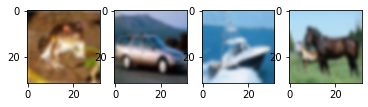

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(141)
plt.imshow(x_train[0], interpolation='bicubic')
plt.grid(False)

plt.subplot(142)
plt.imshow(x_train[4], interpolation='bicubic')
plt.grid(False)

plt.subplot(143)
plt.imshow(x_train[8], interpolation='bicubic')
plt.grid(False)

plt.subplot(144)
plt.imshow(x_train[12], interpolation='bicubic')
plt.grid(False)

plt.show()

In [ ]:
# 자료형을 실수로 변환한 후 정규화
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
# 원핫 인코딩
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train0, NUM_CLASSES)
y_test = to_categorical(y_test0, NUM_CLASSES)
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

## 모델 정의/설정/학습

In [ ]:
model = Sequential()

# 마스크의 갯수(32), 사이즈(3,3)
model.add(Conv2D(32, (3,3), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [ ]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(learning_rate=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
modelpath = 'model/cifar10-cnn-{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss',
                               verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/100
1250/1250 [==============================] - 9s 5ms/step - loss: 2.0584 - accuracy: 0.2357 - val_loss: 1.6267 - val_accuracy: 0.4171

Epoch 00001: val_loss improved from inf to 1.62674, saving model to model/cifar10-cnn-01-1.6267.hdf5
Epoch 2/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6146 - accuracy: 0.4069 - val_loss: 1.4950 - val_accuracy: 0.4579

Epoch 00002: val_loss improved from 1.62674 to 1.49498, saving model to model/cifar10-cnn-02-1.4950.hdf5
Epoch 3/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4546 - accuracy: 0.4704 - val_loss: 1.3586 - val_accuracy: 0.5249

Epoch 00003: val_loss improved from 1.49498 to 1.35859, saving model to model/cifar10-cnn-03-1.3586.hdf5
Epoch 4/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3607 - accuracy: 0.5092 - val_loss: 1.2424 - val_accuracy: 0.5682

Epoch 00004: val_loss improved from 1.35859 to 1.24244, saving model to model/cifar10-cnn-04-1.2424.hdf5


In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('model/cifar10-cnn-43-0.6593.hdf5')

# 테스트 정확도 출력
acc = model.evaluate(x_test, y_test, verbose=2)[1]
print('Test Accuracy: {:.4f}'.format(acc))

313/313 - 1s - loss: 0.6698 - accuracy: 0.7800
Test Accuracy: 0.7800


## 훈련과정 시각화

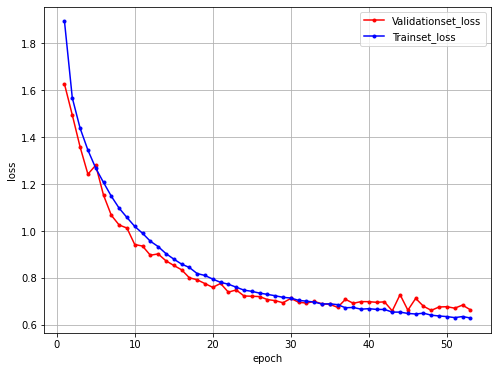

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# 검증셋의 오차
y_vloss = history.history['val_loss']


# 학습셋의 정확도
# y_acc = history.history['accuracy']
y_loss = history.history['loss']

# 그래프로 표현
# x_len = np.arange(1, len(y_acc) + 1)
x_len = np.arange(1, len(y_loss) + 1)

plt.figure(figsize=(8,6))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Validationset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

# 그래프에 그리드를 그리고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()